In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error

from data.city.load_cities import CITY
from data.prediction.methods.mean_predictor import PredictByMean

In [2]:
TRAIN_SIZE = 0.7
method = PredictByMean(city=CITY, train_size=TRAIN_SIZE, prediction_length=168)
method.train()

station = method.df_dataset.columns[0]
r = method.df_dataset[station].iloc[:168]
method.predict(station, r)

2016-04-08 00:00:00    0.112616
2016-04-08 01:00:00    0.127410
2016-04-08 02:00:00    0.126759
2016-04-08 03:00:00    0.170924
2016-04-08 04:00:00    0.305471
                         ...   
2016-04-14 19:00:00    0.146490
2016-04-14 20:00:00    0.137225
2016-04-14 21:00:00    0.120926
2016-04-14 22:00:00    0.123911
2016-04-14 23:00:00    0.104773
Freq: h, Name: Moyenne, Length: 168, dtype: float64

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from data.data import get_interpolated_indices

encoder = {station: code for station, code in zip(method.df_dataset.columns, range(len(method.df_dataset)))}
s = method.df_dataset['00271-ancely']
s = method.df_dataset['00001-poids-de-lhuile']

In [114]:
days, hours = 30, 24
time_window = days * hours
forecasting_window = 168

X = []; y = []
for i in range(0, len(s) - time_window - forecasting_window):
    X.append(s.iloc[i:i + time_window].reset_index(drop=True))
    y.append(s.iloc[i + time_window: i + time_window + forecasting_window].reset_index(drop=True))
X = pd.DataFrame(X)
y = pd.DataFrame(y)

In [67]:
days, hours = 30, 24
time_window = days * hours
forecasting_window = 168

df = method.df_dataset.rename(columns=encoder).reset_index(drop=True)

X: list[pd.Series] = []
for i in tqdm(range(0, len(df) - time_window)):
    X.append(df.iloc[i:i + time_window].reset_index(drop=True).T.reset_index(names='code_station'))
X: pd.DataFrame = pd.concat(X, ignore_index=True)
X.columns = [X.columns[0]] + [f'J{day:0>2}-H{hour:0>2}' for day, hour in zip(sorted(list(range(days)) * hours), list(range(hours)) * days)][::-1]
y = df.iloc[time_window:].stack().reset_index(drop=True)

100%|██████████| 3600/3600 [00:03<00:00, 1113.44it/s]


In [115]:
# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

In [116]:
# Créer un modèle Random Forest
rf = RandomForestRegressor(
    n_estimators=16,
    max_depth=10,
    verbose=2,
    n_jobs=-1
)

# Entraîner le modèle sur les données d'entraînement
rf.fit(X_train, y_train)

# Évaluer le modèle sur les données de test
score = rf.score(X_test, y_test)
score

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.


building tree 1 of 16building tree 2 of 16

building tree 3 of 16
building tree 4 of 16
building tree 5 of 16
building tree 6 of 16
building tree 7 of 16
building tree 8 of 16
building tree 9 of 16
building tree 10 of 16
building tree 11 of 16
building tree 12 of 16
building tree 13 of 16
building tree 14 of 16
building tree 15 of 16
building tree 16 of 16


[Parallel(n_jobs=-1)]: Done   4 out of  16 | elapsed:    4.6s remaining:   13.9s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    4.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    5.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


0.4599096262374181

MSE: 0.08022979572053075


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  12 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  16 out of  16 | elapsed:    0.0s finished


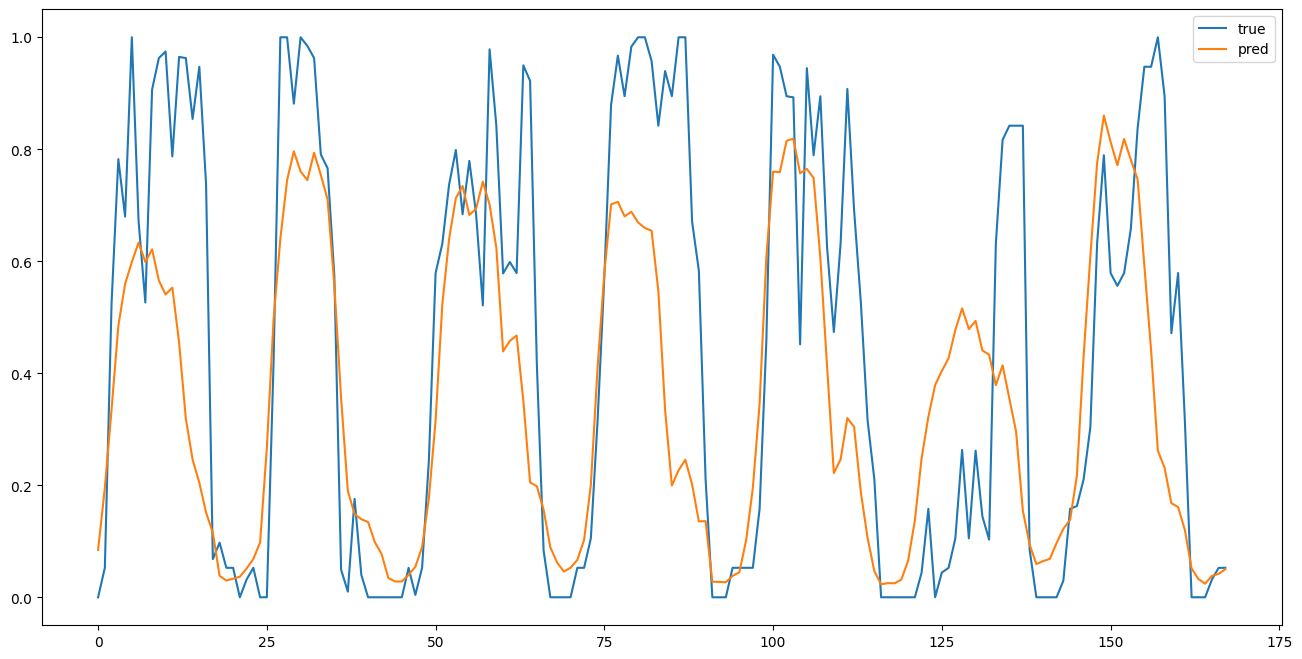

In [117]:
# mask = get_interpolated_indices(y_test)
# inter = pd.Series(1.0, index=y_test.index)
# inter[mask] = 0.0

y_pred = rf.predict(X_test.iloc[0].to_frame().T)
print('MSE:', mean_squared_error(y_test.iloc[0], y_pred[0]))
(pd.DataFrame({'true': y_test.iloc[0], 'pred': y_pred[0]})).plot.line(figsize=(16, 8))
plt.show()